In [1]:
"""nbconvert header

We are just configuring to hide some unnecessary warnings.
"""

import arpes.config

arpes.config.DOCS_BUILD = True

Activating auto-logging. Current session state plus future input saved.
Filename       : logs/unnamed_2024-06-16_12-42-56.log
Mode           : backup
Output logging : False
Raw input log  : False
Timestamping   : False
State          : active


### Iteration across coordinates

`iter_coords` allows you to iterate across the coordinates of a `DataArray`, without also iterating across the data values. This can be useful if you would like to transform the coordinates before selection, or would only like access to the coordinates. 

Here is an example.

In [2]:
import arpes.config
# Set the random seed so that you get the same numbers
import numpy as np

np.random.seed(42)


import xarray as xr
import arpes.xarray_extensions  # so .G is in scope

test_data = xr.DataArray(
    np.random.random((3, 3)), coords={"X": [0, 1, 2], "Y": [-5, -4, -3]}, dims=["X", "Y"]
)
test_data.values

array([[0.37454012, 0.95071431, 0.73199394],
       [0.59865848, 0.15601864, 0.15599452],
       [0.05808361, 0.86617615, 0.60111501]])

In [3]:
for coordinate in test_data.G.iter_coords():
    print(coordinate)

{'X': 0, 'Y': -5}
{'X': 0, 'Y': -4}
{'X': 0, 'Y': -3}
{'X': 1, 'Y': -5}
{'X': 1, 'Y': -4}
{'X': 1, 'Y': -3}
{'X': 2, 'Y': -5}
{'X': 2, 'Y': -4}
{'X': 2, 'Y': -3}


You can also iterate simultaneously over the coordinates and their indices in the data with `enumerate_iter_coords`.

In [4]:
for index, coordinate in test_data.G.enumerate_iter_coords():
    print(index, coordinate)

(0, 0) {'X': 0, 'Y': -5}
(0, 1) {'X': 0, 'Y': -4}
(0, 2) {'X': 0, 'Y': -3}
(1, 0) {'X': 1, 'Y': -5}
(1, 1) {'X': 1, 'Y': -4}
(1, 2) {'X': 1, 'Y': -3}
(2, 0) {'X': 2, 'Y': -5}
(2, 1) {'X': 2, 'Y': -4}
(2, 2) {'X': 2, 'Y': -3}


## Raveling/Flattening

It is sometimes necessary to have access to the data in a flat format where each of the coordinates has the full size of the data. The most common usecase is in preparing an isosurface plot, but this functionality is also used internally in the coordinate conversion code.

The return value is a dictionary, with keys equal to all the dimension names, plus a special key "data" for the values of the array.

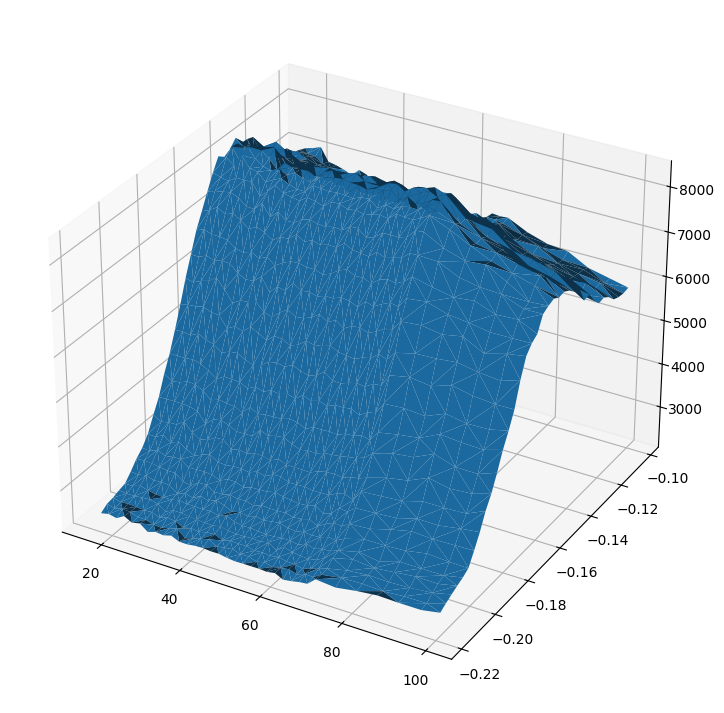

In [5]:
from arpes.io import example_data
import matplotlib.pyplot as plt

data = example_data.temperature_dependence.spectrum.sel(
    eV=slice(-0.08, 0.05), phi=slice(-0.22, None)
).sum("eV")

raveled = data.G.ravel()
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(projection="3d")

ax.plot_trisurf(
    raveled["temperature"],  # use temperature as the X coordinates
    raveled["phi"],  # use phi as the Y coordinates
    data.values.T.ravel(),  # use the intensity as the Z coordinate
)

## Coordinate manipulation

You can also get a flat representation of the coordinates and data of a one dimensional dataset using `to_arrays`. This is especially valuable since the result can be [* splatted](https://docs.python.org/3/tutorial/controlflow.html#unpacking-argument-lists) into an invocation of a scatter plot.

In [6]:
one_dim = test_data.sum("X")
one_dim

<xarray.DataArray (Y: 3)> Size: 24B
array([1.03128222, 1.97290909, 1.48910347])
Coordinates:
  * Y        (Y) int64 24B -5 -4 -3

In [7]:
one_dim.G.to_arrays()

(array([-5, -4, -3]), array([1.03128222, 1.97290909, 1.48910347]))

## Functional Programming Primitives: `filter` and `map`

You can `filter` or conditionally remove some of a datasets contents. To do this over coordinates on a dataset according to a function/sieve which accepts the coordinate and data value, you can use `filter_coord`. The sieving function should accept two arguments, the coordinate and the cut at that coordinate respectively. You can specify which coordinate or coordinates are iterated across when filtering using the `coordinate_name` paramter.

As a simple, example, we can remove all the odd valued coordinates along Y:

In [8]:
test_data.G.filter_coord("Y", lambda y, _: y % 2 == 0)

<xarray.DataArray (X: 3, Y: 1)> Size: 24B
array([[0.95071431],
       [0.15601864],
       [0.86617615]])
Coordinates:
  * X        (X) int64 24B 0 1 2
  * Y        (Y) int64 8B -4

Functional programming can also be used to modify data. With `map` we can apply a function onto a `DataArray`'s values. You can use this to add one to all of the elements:

In [9]:
test_data.G.map(lambda v: v + 1)

<xarray.DataArray (X: 3, Y: 3)> Size: 72B
array([[1.37454012, 1.95071431, 1.73199394],
       [1.59865848, 1.15601864, 1.15599452],
       [1.05808361, 1.86617615, 1.60111501]])
Coordinates:
  * X        (X) int64 24B 0 1 2
  * Y        (Y) int64 24B -5 -4 -3

Additionally, we can simultaneously iterate and apply a function onto a specified dimension of the data with `map_axes`. Here we can use this to ensure that the rows along `Y` have unit norm.

In [10]:
test_data.G.map_axes("Y", lambda v, c: v / np.linalg.norm(v))

<xarray.DataArray (X: 3, Y: 3)> Size: 72B
array([[0.52859931, 0.73382829, 0.76253974],
       [0.84490405, 0.12042618, 0.16250411],
       [0.08197508, 0.66857578, 0.62619929]])
Coordinates:
  * X        (X) int64 24B 0 1 2
  * Y        (Y) int64 24B -5 -4 -3

## Shifting

Suppose you have a bundle of spaghetti in your hand with varying lengths. You might want to align them so that they all meet in a flat plane at the tops of the strands. In general, you will have to shift each a different amount depending on the length of each strand, and its initial position in your hand.

A similar problem presents itself in multidimensional data. You might want to shift 1D or 2D "strands" of data by differing amounts along an axis. One practical use case in ARPES is to [align the chemical potential](/fermi-edge-correction) to take into account the spectrometer calibration and shape of the spectrometer entrance slit. Using the curve fitting data we explored in the previous section, we can align the data as a function of the temperature so that all the Fermi momenta are at the same index:



Fitting on pool...:   0%|          | 0/34 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Shifted to align Fermi angle')

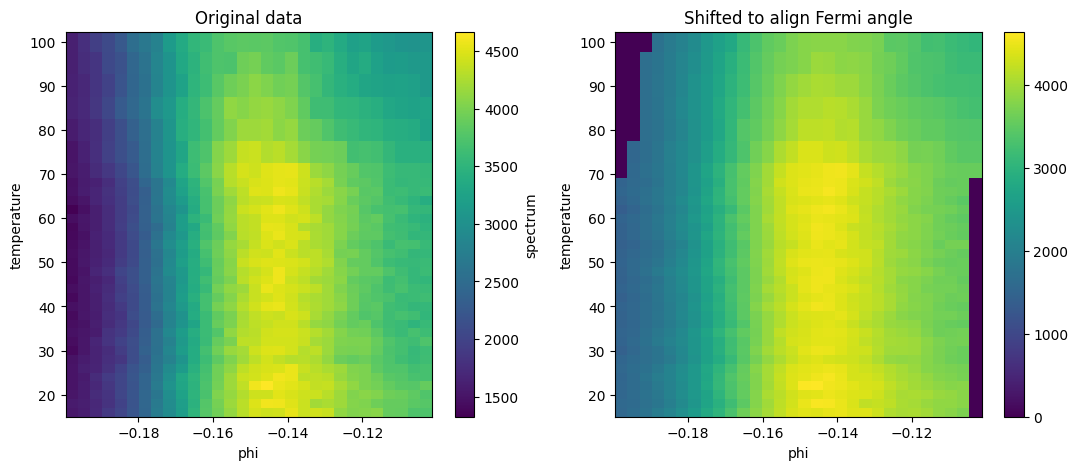

In [11]:
# first, get the same cut and fermi angles/momenta from the previous page
# this is reproduced for clarity and so you can run the whole notebook
# please feel free to skip...

from arpes.fits.utilities import broadcast_model
from arpes.fits.fit_models import LorentzianModel, AffineBackgroundModel

temp_dep = example_data.temperature_dependence
near_ef = temp_dep.sel(eV=slice(-0.05, 0.05), phi=slice(-0.2, None)).sum("eV").spectrum

phis = broadcast_model(
    [AffineBackgroundModel, LorentzianModel],
    near_ef,
    "temperature",
).results.F.p("b_center")

# ...to here
fig, ax = plt.subplots(1, 2, figsize=(13, 5))
near_ef.S.plot(ax=ax[0])
near_ef.G.shift_by(phis - phis.mean(), shift_axis="phi").S.plot(ax=ax[1])

ax[0].set_title("Original data")
ax[1].set_title("Shifted to align Fermi angle")